# AESB2121 Practicum 1 - Geophone on a Cantilever Beam

Based on an assignment by Prabu Dheenathayalan,
and updated by Han Dun <h.dun@tudelft.nl>, and Paco López-Dekker <F.LopezDekker@tudelft.nl>, October 2019 and September 2023
First we import the python packages that we need...

In [2]:
import nidaqmx
import numpy as np
import scipy.signal as signal
import os
from matplotlib import pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'nidaqmx'

# Theory
A data acquisition (DAQ) system usually consists of the following four components:
1. A sensor transforms a physical signal into a small voltage. The transformation is often frequency dependent or nonlinear, and can show drift or bias.
2. Signal conditioning electronics (often included in the sensor housing) filter unwanted frequencies, such as the 50 Hz line frequency caused by power plant generators, using low-pass or notch filters. In addition the sensor voltage may be amplified.
3. An analog-to-digital (A/D) converter samples the analog voltage with a certain rate, such as 100Hz. The A/D converter can measure analog voltages within a certain range, the measurement range. The measured voltage is digitized, or quantized, with a certain resolution, such as 14 bit (in our case), which means that the full measurement range is divided into $2ˆ14 = 16384$ discrete intervals. Together, the resolution and measurement range determine the precision. Usually the sample rate, the measurement range, and the sample resolution are configurable.
4. A digital computer reads the sampled data from the A/D converter at specific times, and allows for further processing, analysis and storage of the (digital) signal.

Each of these components affects how the analog signal arrives in the digital computer, and understanding how these components work and can be configured is very important. This will be demonstrated using the geophone suspended at point P on a cantilever beam shown in te figure below.
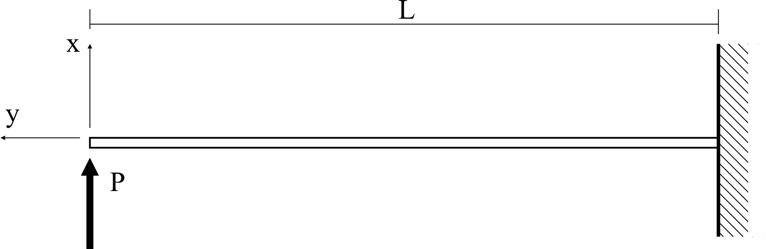

Geophones are remarkably simple (yet ingenious) devices which – broadly spoken – convert movement (displacement) into an electric signal. It consists of a copper wire-wrapped mass which can move up and down surrounded by a fixed ring shaped magnet. The mass is suspended on top and at bottom by springs. When there is a motion (ground motion during Earthquake, or an artificially triggered motion) the coil moves up and down, thereby cutting the magnetic field. This produces an electrical voltage in the wire. The voltage recorded is proportional to the **velocity** (speed) at which the coil moves, which in turn is a measure of motion we would like to measure. In our experiment we will be using a passive geophone and hence we do not need to power this device externally.

A theoretical description of the motion of the geophone suspended at point P on the cantilever beam is presented in Appendix A. Pulling down the beam at the tip and releasing it, results in a vertical up and down motion of the geophone, and the (vertical) position can be described by a damped harmonic as a function of time. Consequently, also the first derivative (with respect to time) – the velocity as a function of time as the geophone will measure it – is a harmonic.

<!-- In the previous part, the experimental set-up has been explained, as well as the post-processing tools (Fast Fourier Transform, FFT) and some effects of measurement time duration and sampling rate. In the second part you will perform some measurements yourself. -->

## Some sampling theory

In module 5, towards the end of the course, we will discuss in some depth sampling theory. A fundamental question there is: **how often should I sample a signal to be able to fully reconstruct it from the samples?** This is answered by the *Nyquist-Shannon* sampling theorem. For *baseband* signals, that means for signals with frequency components centered around $f=0$, the theorem states the sampling frequency, $F_s$, should be at least twice as large as the *bandwidth*, $B$,  of the signal:
$$F_s>2B$$
For now, you can interpret the bandwidth as the maximum frequency contained in our signal, $f_{max}$.

## Measurement  Setup
As explained, a general data acquisition system contains a sensor, signal conditioning electronics, an Analog-to-Digital Converter (ADC) and a digital computer for post-processing. 
- The sensor unit is nothing but a geophone. The voltage recorded is proportional to the velocity (speed) at which the coil moves, which in turn is a measure of motion we would like to measure. In our experiment we will be using a passive geophone and hence we do not need to power this device externally.
- An external analog filter will not be included in our lab experiment session.
- We use the National Instruments USB-6009 4 channel ADC. The input measurement range is adjustable in steps: from -1…1, -5…5, -10…10 and -20…20 V.The ADC has a 14 bit resolution, meaning that the selected measurement range is subdivided into $2^{14}$ = 16,384 discrete intervals.

    A maximum sample rate of 48,000 samples per second can be achieved by the ADC. The actual sample rate is depending on the number of channels that are sampled at the same time, since a multiplexer is used. A multiplexer passes all the channels that need to be sampled one by one very quickly to the ADC. So if four channels are sampled, the effective sample rate per channel drops to 12,000 samples per second.

Before using the geophone, we should install **nidaqmx** package which contains an API for interacting with the NI-DAQmx driver. You can open th Anaconda Prompt and type in 
```
python -m pip install nidaqmx
```

Then, connect the USB-cable of the A/D converter to the PC (the green LED on top of the A/D converter should get active).



<!-- # Simulating (simple) Signals
Computers are extremely useful to analyze and simulate signals or signals and systems. A limitation we have, however, is that we cannot work with continuous signals (unless we use symbolic math tools). We can simulate continuous time signals using discrete time signals as long as the signals are _sampled_ with a high enough sampling frequency. Anyhow let us start with something simple. -->

# The Discrete Fourier Transform (DFT)

We are going to want to look at signals in the frequency domain. However, we cannot apply the continuous time fourier transform (discussed in Module 4, but already introduced when we defined the frequency response of a system)
$$
  X(f)=\int_{-\infty}^{\infty} x(t)\cdot e^{-j2\pi f t} dt.
$$
Instead, we will use the **DFT** (a.k.a. FFT, but this is a bit of name abuse).
The Discrete Fourier Transform is the discrete time counterpart of the Discrete Fourier Series. In fact, it can be shown that, up to some normalization factor, the values of the DFT correspond to the Fourier Series coefficients of a band limited periodic signal (assuming that the sampling frequency is *Nyquist compliant*.

## Quick summary
The DFT is typically defined as
$$ X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j2\pi\frac{k\cdot n}{N}} $$
with corresponding inverse DFT given by
$$ x[n] = \frac{1}{N}\sum_{k=0}^{N-1} X[k] \cdot e^{j2\pi\frac{k\cdot n}{N}}, $$
where N is the number of samples considered. In the literature (or books, or lecture notes) you may find the discrete signals written as $x_n$ and $X_k$ instead of $x[n]$ and $X[k]$, but this is mostly a matter of personal preference.

More often than not, the discrete samples $x[n]$ are samples of a continuous time signal, $x(t)$:
$$ x[n] = x(n\cdot T_s),$$
where $T_s$ is the sampling interval (which you may find expressed as $\Delta t$).
In that case, the discrete frequency bins, correspond to a continuous time frequency:
$$ f_k = \frac{k}{N}\cdot F_s = \frac{k}{N\cdot T_s}.$$

For convention, we use values of $k$ ranging from 0 to N-1, but we should keep in mind that the upper N/2 values correspond to *negative frequencies*. For plotting purposes we typically circularly shift the frequency domain representation of the signal. For spectral analysis of sampled continuous time signals one should generate the corresponding frequency axis.

## Things to keep in mind

* When we use a DFT we are implictly assuming that we are working with a periodic signal. This has implications. For example, when you decide to do a time-domain convolution by going to the frequency domain, multiplying the two signals, and going back to the time domain, what you have done is a **circular** convolution. 
* Because you are treating your segment signal as a periodic signal, the smallest non-zero frequency you see is $\frac{1}{N\cdot T_s} = \frac{1}{T}$. This is also the **spectral resolution**. If you want to improve your spectral resolution, then you need more samples.
* Since usually your time-domain signal is not periodic (or does not have $T= N\cdot T_s$ as its period) you will have a discontinuity at the edges. This introduces high frequency components in your DFT that typically do not correspond to actual frequency components in your continuous time signal. We usually apply some tapering to the signal, by multiplying it by a windowing funtion (e.g. a Hamming or a Hanning window).

## The DFT in Numpy

As you may know already, Numpy offers functions to compute the DFT. It uses so-called Fast Fourier Transform (FFT) algorithm.
Say that you have generated a vector of data, for example, we could have generated a sequency 128 random samples with a sampling time $T_s=0.001$ s (1 ms):
```
npts = 128
Ts = 0.001 
x = np.random.randn(npts)
```
Now we can compute the DFT of this signal doing
```
x_f = np.fft.fft(x)
```
It is usefult to know the frequency that corresponds to each point in the discrete Fourier transformed signal. In general, one would just use the ```fftfreq``` function:
```
freqs = np.fft.fftfreq(npts, Ts)
```
Finally, you would want to represent the frequency domain signal, remembering that:
1. You typically want to reorder the signal using ```fftshift```;
2. You want to show either the real and imaginary part, or the amplitude and the phase

For example, the next cell runs the code just discussed, creates a little plotting function, and generates the corresponding plot



In [ ]:
npts = 128
# sampling time
Ts = 0.001 
x = np.random.randn(npts)
x_f = np.fft.fft(x)
freqs = np.fft.fftfreq(npts, Ts)
# For later purposes, I also generate a time vector
t_v = np.arange(npts) * Ts
# Plotting function
def plot_dft_real_imag(freq_vector, dft_vector):
    """ This functino plots the real and imagnary part of dft_vector
        :param freq_vector: a numpy array with the frequecy of each point of the dft
        :param dft_vector: self-evident
    """
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(np.fft.fftshift(freq_vector), np.fft.fftshift(np.real(dft_vector)),label='Real Part')
    plt.grid(True)
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(np.fft.fftshift(freq_vector), np.fft.fftshift(np.imag(dft_vector)),label='Imaginary Part')
    plt.xlabel('f [Hz]')
    plt.legend()
    plt.grid(True)
# Use it on generated data
plot_dft_real_imag(freqs, x_f)

In the first part of this assignment, we will take damping ratio zero and use a fairly short measurement time (duration), and hence the velocity measured by the geophone is a plain (undamped) sinusoid as shown in Appendix A. In the following exercises we added a phase offset $\varphi$ to the plain sinusoid just for generality:
$$
  x_1(t) = A \sin(2\pi f_n t + \varphi)
$$

## <font color='blue'> Exercise 1</font>
 First we are going to _play_ a bit with the this signal. To do things a bit nice let us define a function `x_sim(t)` that returns the signal as a function of time. In this case we also give it some default parameters

In [ ]:
def x_sim(t, A=1, fn=1, phi_deg=5):
    return A * np.sin(2 * np.pi * fn * t + np.radians(phi_deg))

Now let us create a time vector of times in the interval $t\in [0, 10]$ with a sampling frequency $F_s=10$ Hz. Plot the signal `x_sim` as a function of time.

In [ ]:
# Change what is needed in the code...
# Time vector
Fs = 20
# sampling interval
Ts = 1 / Fs
t_max = 2
n_samples = int(t_max * Fs)
t = np.arange(n_samples) * Ts
data_sim = x_sim(t)
plt.figure()
plt.plot(t, data_sim)

Now we want to analyze the signal in the spectral domain. You have already studied and learned how to use the DFT (FFT algorithm) to analyze the _spectrum_ of the signal. Simplifying a lot, to analyze the power _spectrum_ of a continuous time signal,you would take the signal, $x(t)$, compute its Fourier transform, $X(f)$, and look at its absolute value squared, $|X(f)|^2$.

We want to see how it looks like for different values of the sampling frequency, $F_s$, and the number of samples, $N$.

For a given $F_s$ (`Fs`) and N we can generate a time vector
```
Ts=1/Fs
t = np.arange(N) * Ts
```
and then the samples of our signal
```
x_n = x1(t)
```
You can let numpy compute the frequency vector and the FFT
```
f_k = np.fft.fftfreq(N, Ts)
X_k = np.fft.fft(x_n)
```
To compute the spectral power density, we need to normalize a bit. It is not that relevant in the current context, but  why not do it. The normalized **energy spectral density** can be computed with
```
S = (np.abs(X_k) * Ts)**2 
```
This has units of J/Hz. 

To visualize the plots we can use a logarithmic y-scale (after creating the plot, use:
```
plt.yscale('log') )
```

We plot only the positive frequencies (`plt.xlim(0, f_max)`), setting the maximum frequency according to Nyquist theorem.

In [ ]:
# Your code here....
def plot_spectrum(data, Fs, tplot=False, stem=False, log=True):
    Ts=1/Fs
    N = data.size
    t = np.arange(N) * Ts
    f_k = np.fft.fftfreq(N, Ts)
    X_k = np.fft.fft(data)
    S = (np.abs(X_k) * Ts)**2
    f_max = f_k.max()
    if tplot:
        plt.figure()
        plt.plot(t, data)
        plt.xlabel("t [s]")
    plt.figure()
    if stem:
        plt.stem(np.fft.fftshift(f_k), np.fft.fftshift(S))
    else:
        plt.plot(np.fft.fftshift(f_k), np.fft.fftshift(S))
    if log:
        plt.yscale('log')
    plt.xlim(0, f_max)
    plt.xlabel("f [Hz]")
    
plot_spectrum(data_sim, Fs, tplot=True, stem=True, log=False)
plot_spectrum(data_sim, Fs)

**Try the following**:
1. Set the oscillating frequency $f_n$ to 5 Hz, the sampling frequency to 100 Hz and take 200 samples, i.e 2 seconds. Use the function above to make the time-domain plot and to visualize the spectrum.
2. Change on the the Fs, setting it to 20 Hz, and reducing the number of samples to 40.
3. Now set $f_n$ to 105 Hz, $F_s$ back to 100 Hz, and the number of samples back to 200.

**Discuss what you see, relate it to the Nyquist-Shannon theorem**

In [ ]:
#You can uncomment and play with these lines of code
# Fs = 100
# n_samples = int(2*Fs)
# t = np.arange(n_samples) / Fs
# plot_spectrum(x_sim(t, fn=105), Fs, tplot=True, stem=False, log=True)

**try one more thing**: set the oscillating frequency $f_n$ to 5.25 Hz, the sampling frequency to 100 Hz and take 200 samples, i.e 2 seconds. Use the function above to make the time-domain plot and to visualize the spectrum. You should observe what we call _spectral leakage_. 

In [ ]:
# Fs = 100
# n_samples = int(2*Fs)
# t = np.arange(n_samples) / Fs
# plot_spectrum(x_sim(t, fn=5.25), Fs, tplot=True, stem=False, log=True)

# Playing with the geophone

Use the following command to check if the device you plugged in is detected 

In [ ]:
system = nidaqmx.system.System.local()
print(system.driver_version)

for device in system.devices:
    print(device)

It should say at least one data acquisition device is connected. Note down the ‘Device ID’ of the National Instruments USB-6009; likely it is `Dev1` or `Dev2`.

Afterwards, we can create a task and add one analog analog input virtual channel (i.e., `ai0`). The expected voltage range of the geophone is approximately between -1 and 1 Volt. Since the closest measurement range available on the NI USB-6009 is -4...4 V, so we let the minimum voltage be -4 and the maximum voltage be 4, using the following comment,

```
ai_channel = task.ai_channels.add_ai_voltage_chan("Dev2/ai0",min_val=-4,max_val=4)
```

Finally we set number of samples $N$ read from the ADC, and its sample rate $f_s$. The number of samples $N$ indicates the measurement duration $T_{meas}$, once we know the sampling rate $f_s$, $T_{meas} = \frac{N}{f_s}$. Hence we can configure the ADC using the following comment:

```
task.timing.cfg_samp_clk_timing(Samples_Per_Sec, samps_per_chan=Samples_Per_Ch_To_Read)
```

For example, we want to measure the signal with a duration $T_{meas}$ of 10 seconds and the sampling frequency $f_s$ of 100 Hz. Since the sampling rate $f_s$ is 100 Hz, there will be 100 samples acquired very second, and the number of samples $N$ read from the ADC should be set to 1000 samples. 

You can use the following comment to configure the ADC, and the data is store in the array `data`

In [ ]:
# Define a little function to collect some data
def acquire_data(dev, sampling_frequency, n_samples,max_volt=4):
    """
    This function acquires some data
    dev: string with the name of the device, e.g. "Dev1"
    sampling_frequency: number of samples per second
    n_samples: number of samples acquired
    """
    device = dev + "/ai0"
    with nidaqmx.Task() as task:
        ai_channel = task.ai_channels.add_ai_voltage_chan(device,min_val=-max_volt,max_val=max_volt)
        print(ai_channel.ai_term_cfg)
        task.timing.cfg_samp_clk_timing(Samples_Per_Sec, samps_per_chan=Samples_Per_Ch_To_Read)
        data = task.read(Samples_Per_Ch_To_Read)
    return data



In [ ]:
Samples_Per_Sec = 100  # sample clock rate
Samples_Per_Ch_To_Read = 1000 # num of samples
data = acquire_data(dev, Samples_Per_Sec, Samples_Per_Ch_To_Read ,max_volt=4)

Now we can plot the samples we aquired. Again, the samples have been stored in the array `data`

In [ ]:
# We make a time vector with the times of each sample
# Time between samples:
Ts = 1 / Samples_Per_Sec
time = np.arange(0,Samples_Per_Ch_To_Read) * Ts
plt.plot(time,data)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.show()

## <font color='blue'> Exercise 2</font>
Make sure you have connected the A/D converter to your PC USB port. Keep the metal beam at stand still condition (metal plate not moving). Tip: place the wooden block in between wooden frame and metal plate to arrest the oscillation of the metal plate.

Now configure the A/D converter to measure at 5 samples per second for a measurement time duration of 50 seconds   

- What should be the maximum frequency component in the signal, in order to properly measure the spectrum with this sampling rate?
- Plot the *velocity* signal against time. Is the signal zero at time t = 0s ? 
- Calculate the average voltage of the *velocity* signal. 
- Remove the mean from the *velocity* signal. Then calculate the Fast Fourier Transform, and plot the modulus. Please **consider** if you want to use log scales for the axes (with `plt.xaxis('log')` and/or `plt.yaxis('log')`).
- Do you see any one dominant frequency after removing the mean?

**Use the functions previously defined for your plots!**

In [ ]:
# your code here ...

your answers here ...

Since the AD converter is configured in ‘Differential’ input mode, a constant offset is introduced in the measured velocity signal. Therefore the mean of the measured signal is to be computed and subtracted (removed) from the measured signal. Now it is time to start measuring beam deflection with the geophone in motion. First let’s try to determine the oscillation frequency.
## <font color='blue'> Exercise 3</font>
Make sure that the metal plate is level, and that the wooden frame is stable on the desk.

Configure the A/D converter to measure at 5 samples per second for a measurement time of 50 seconds.Gently pull the beam about 1 cm down at the tip, and start measuring after you released the beam
- What should be the maximum frequency component in the signal, in order to properly measure the spectrum with this sampling rate?
- Plot the *velocity* signal against time. Is the signal zero at time $t$ = 0 s (i.e. is the first observation value equal to zero)? 
- Is it a pure periodic oscillation? Justify your answer.
- Remove the mean from the _velocity_ signal. Then calculate the Fast Fourier Transform, and plot the modulus (log axes?).
- Do you see any dominant frequency after removing the mean? If any, what is the frequency? 
- Now increase the sampling frequency from 5 Hz to 10 Hz and 20 Hz. Do you see any dominant frequency after removing the mean? If any, what is the frequency?
- Can you explain why we first saw a peak at a lower frequency when you sampled at 5 Hz?
- Can you figure out the relationship between the sample rate and the frequency of the aliased signal?

In [ ]:
# Your code here ...

Your answer here....

## <font color='blue'> Exercise 4</font>
Make sure that the metal plate is level, and that the wooden frame is stable.

Configure the A/D converter to measure at 10 samples per second for a measurement time of 5 seconds. Gently pull the beam about 1 cm down at the tip, and start measuring _after_ you released the beam. Remove the mean from the _velocity_ signal. Calculate the Fast Fourier Transform of the velocity, and plot the modulus.

- Determine the spectral resolution. 
- Determine the dominant frequency from the plotted amplitude spectrum. 

In [ ]:
# Your script here ...

Your answer here...

You might have noticed that the frequency resolution $f_0$ is rather low. We would like to increase it.
## <font color='blue'> Exercise 5</font>
- Perform the necessary adjustment to the A/D converter’s settings to decrease the base frequency to 0.025 Hz. Does a higher sample rate work?    
- Does a longer measurement time duration work?
- Repeat the measurement of Exercise 3 with a frequency resolution of 0.025 Hz. What is the measurement duration? 
- Remove the mean from the _velocity_ signal. Visualize the signal and its power spectrum. Determine the oscillation frequency from the amplitude spectrum.
- Describe the trade off between getting a higher frequency resolution and the fact that our signal needs to be periodic with respect to the measurement time (duration). Is it possible to decrease the base frequency to 0.0025 Hz? For how long would you have to measure?

In [ ]:
# Your script here ...

Your answer here ...

The frequency domain plots in Exercise 3 and Exercise 4 do not show a crisp peak at one specific frequency. In the theoretical part we have seen that this can be caused by the tiniest amount of leakage.
Actually, there is a second reason why we don’t see a crisp spike. Remember that only a pure sinusoid $x(t)=A\sin(2\pi{f}t)$ shows up as a spike. But our beam’s oscillation is **damped**, which means that our amplitude decreases with time 
<center>$\dot{x}(t)=\frac{x(0)}{\sqrt{1-\zeta^2}}\exp(-\zeta\omega_0t)\sin(\omega_dt)$</center>
where $x(0)$ denotes the initial position $x(t=0)$, $\zeta$ denotes the dampling ratio, $\omega_0$ denotes the (undamped) nature frequency, $\omega_d$ is the damped frequency written as $\omega_d=\omega_0\sqrt{1-\zeta^2}$.

## <font color='blue'> Exercise 6 (modifying the dynamic system) </font>
Make sure that the metal plate is level, and that the wooden frame is stable.

Configure the A/D converter to measure at 10 samples per second for a measurement time duration of 50 seconds. Gently pull the beam about 1 cm down at the tip, and start measuring _after_ you released the beam.

Remove the mean from the _velocity_ signal. Calculate the Fast Fourier Transform of the velocity, and plot the modulus. 

Now place a weight of around 100 gram on top of geo-phone. Tip: use your mobile phone as the weight. Gently pull the beam about 1 cm down at the tip, and measure again _after_ you released the beam.

- Remove the mean from the _velocity_ signal. Plot the signal in time and frequency domain. Find the oscillation frequency.
- Comment on the rate of damping, damping time and oscillation frequency before and after adding weight.

In [ ]:
# Your script here ...

Your answer here ...

It is very common for any sensor to have sensor **noise** due to various reasons. But there are two ways to reduce the noise: we can use digital _oversampling_, or we can apply an _analog filter_.
Oversampling consists of sampling much faster than we actually need based on the frequency components in our signal. So instead of sampling at 100 Hz, we could sample at 10,000 Hz and average over 100 samples to obtain a 100 Hz sampled signal. Let’s try this.

## <font color='blue'> Exercise 7</font>
Make sure that the metal plate is level, and that the wooden frame is stable.

Configure the A/D converter to measure at 100 samples per second for a measurement time of 50 seconds.

Gently pull the beam about 1 cm down at the tip, and start measuring after you released the beam.

Remove the mean from the _velocity_ signal. Then calculate the Fast Fourier Transform of the velocity, and plot the modulus. 

Repeat the first part of Exercise 6, but now sample at 10,000 Hz for 50 seconds. Create two signals from these samples. **First** average each time over 100 samples to create a 100 Hz signal (**oversampled** and subsequently **filtered** signal). Hint: average first 100 samples and take it as a first sample, average the second 100 samples and take it as second sample, and so on. To achieve this task a simple brute force implementation might need the for-loop (k=1:5000), but of course you can use your creativity and make it efficient. **Secondly**, just pick each time a single sample, out of a sequence of 100 samples, this yields a socalled **sub-sampled** signal (actually equivalent to sampling at 100 Hz right-away). Compare these two signals.

- Plot the time-domain signal of the (filtered) velocity and compare it to the sub-sampled signal. Hint: Largely zoom-in on the time plot and make your comments (with embedded plots, you can zoom in by setting the plot limits, e.g.`plt.xlim((xmin, xmax))`).
- Calculate the Fast Fourier Transform of the (filtered) velocity, and plot the modulus in a plot (decide yourself if you need logarithmic axes). Compare it to the sub-sampled signal.

In [ ]:
# Your code here ...

Your answer here ...

Oversampling requires digital post-processing, and you might have noticed that this can cost quite some calculation effort. Another way of reducing noise is using an analog filter with an appropriate corner frequency as explained in the previous lab assignment.